In [1]:
#!/usr/bin/env python
# coding: utf-8

import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True, font='Helvetica')

# Set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIG_SIZE = 10

plt.rcParams.update({
    'legend.loc': 'center left',
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'font.size': BIG_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,  # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE, # fontsize of the x and y labels
    'xtick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'ytick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE, # legend fontsize
    'figure.titlesize': BIG_SIZE,   # fontsize of the figure title
    'figure.figsize': (6,3),
    'figure.dpi': 120
})

This report examines why the distribution of total scores has multiple peaks. It seems that the nucleotide minimizes to one of three conformations depending on the position being mutated by cartesian_ddg. Fortunately, because a new rotamer is chosen and the environment minimized for WT as well, the new nucleotide atom coordinates should be the same for a given MUT and WT simulation, so that the change in energy because of the new coordinates should be subtracted out. While we can't confirm this (because I didn't save WT structures out), the correlation between total_score and ddg is the same for each of the three groups of mutations (defined by the different total_score populations)

In [75]:
df = pd.read_csv('20200806_gsp1_ddg_with_scores.csv')

aa_grouping = ['W','Y','F','M','L','I','V','A','C','G',
               'P','T','S','Q','N','E','D','H','R','K']

df.aa_to = df.aa_to.astype("category")
df.aa_to.cat.set_categories(aa_grouping, inplace=True)

df_MUT = df[df.run_type == 'MUT']
df_WT = df[df.run_type == 'WT']

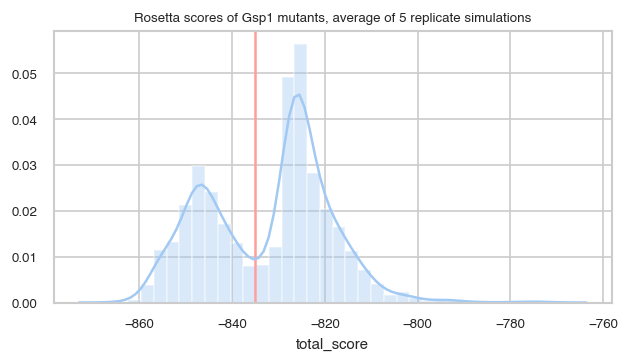

In [76]:
fig = plt.figure(figsize=(6, 3))
plt.axvline(-835, 0, 1, color='r')
plt.title('Rosetta scores of Gsp1 mutants, average of 5 replicate simulations')
g = sns.distplot(df_MUT.total_score)

Here we see that the score of these mutants is essentially positions dependent, and independent of side chain identity other than P, and in some cases Y and W. This strongly suggests that it is the minimization step, which is restricted to a local neighborhood around a residue, that matters

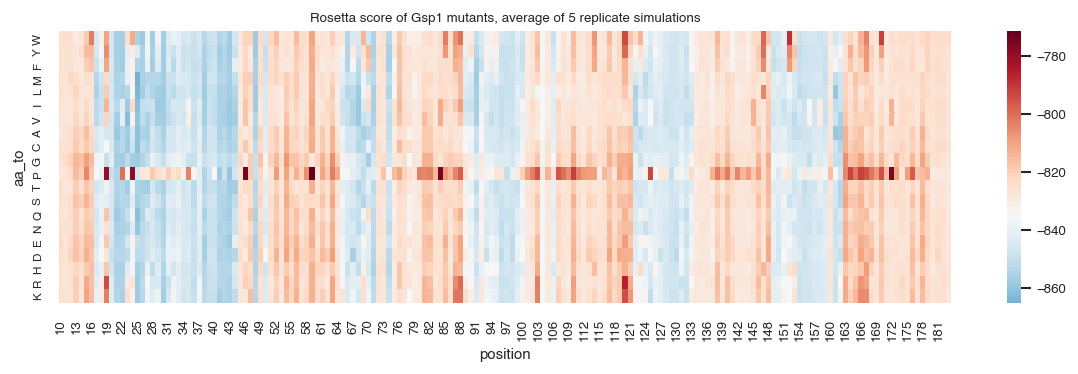

In [77]:
fig = plt.figure(figsize=(12, 3))
plt.yticks(fontsize=7)
plt.title('Rosetta score of Gsp1 mutants, average of 5 replicate simulations')
g = (df_MUT
 .pivot(index='aa_to', columns='position', values='total_score')
 .pipe(sns.heatmap, cmap='RdBu_r', center=-835)
)

This could be the source for some of our ddG signal, as the ddG also seems to have a significant position-dependence

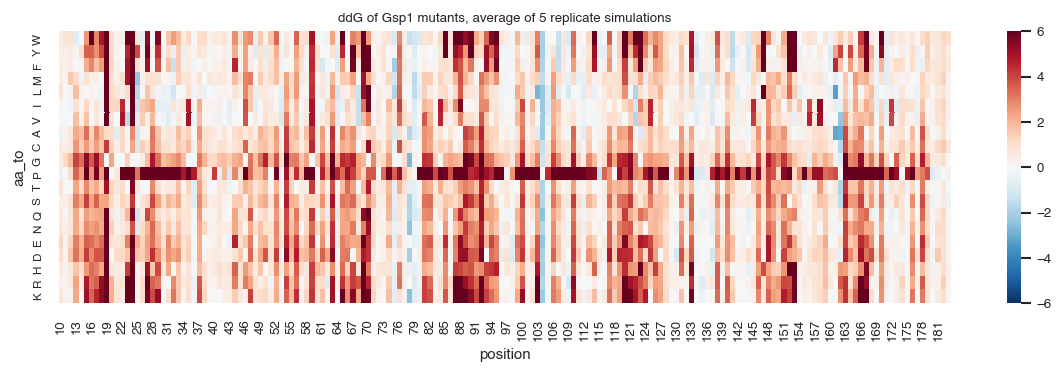

In [81]:
fig = plt.figure(figsize=(12, 3))
plt.yticks(fontsize=7)
plt.title('ddG of Gsp1 mutants, average of 5 replicate simulations')
g = (df_MUT
 .pivot(index='aa_to', columns='position', values='ddg')
 .pipe(sns.heatmap, cmap='RdBu_r', center=0, vmin=-6, vmax=6)
)

This could be a problem if the WT score is different for different ddG calculations, as they will no longer be comparable. THere seems to be three populations of WT.

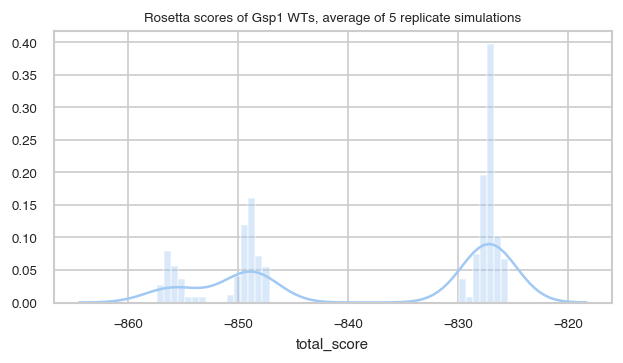

In [82]:
fig = plt.figure(figsize=(6, 3))
plt.title('Rosetta scores of Gsp1 WTs, average of 5 replicate simulations')
g = sns.distplot(df_WT.total_score, bins = 50)

Fortunately, the relationship between ddG and total_score is the same for each of the three groups. That is, even though the WT scores are different for each of the three populations, it seems like the distribution of ddGs is approximately the same, and the WT score is about the same between points in the same population (seen in the fact that the relationship is linear for each population, and it is the same slope across populations). There is of course some variability in the WT scores, but the scores being strongly linear suggests that it is small compared to the measured ddG values.

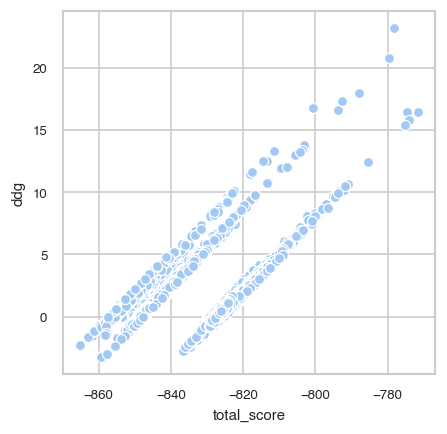

In [83]:
fig = plt.figure(figsize=(4, 4))
g = sns.scatterplot(data=df_MUT, x='total_score', y='ddg')

<AxesSubplot:xlabel='total_score', ylabel='ddg'>

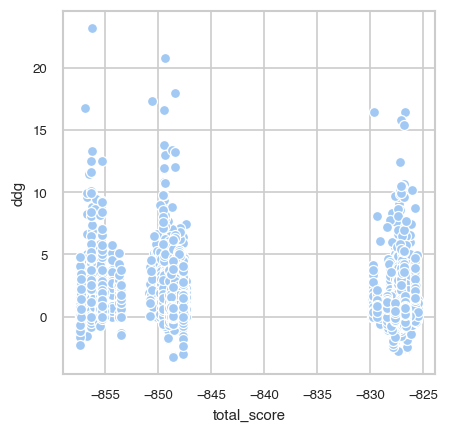

In [84]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_WT, x='total_score', y='ddg')

Below, we again see that the populations are not evenly dispersed, i.e. different regions of the proteins seem to result in different WT structure scores after the neighborhood around that mutation is minimized

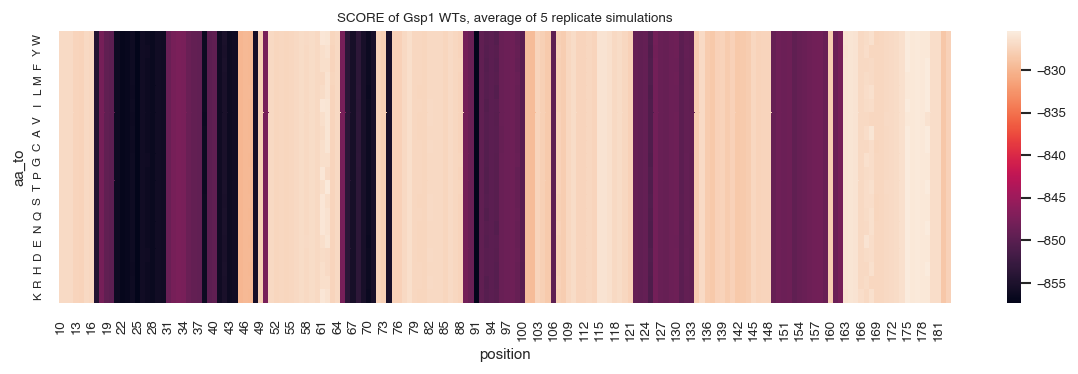

In [85]:
fig = plt.figure(figsize=(12, 3))
plt.yticks(fontsize=7)
plt.title('SCORE of Gsp1 WTs, average of 5 replicate simulations')
g = (df_WT
 .pivot(index='aa_to', columns='position', values='total_score')
 .pipe(sns.heatmap)
)

One thing we can do is look at the nucleotide energy scores from the corresponding MUT pdbs to see if the nucleotide conformations and resulting energies can explain the three populations of total_scores in the WT data.

In [86]:
# extract the nucleotide energies from all of the saved MUT pdbs (unfortunately I did not figure out
# how to save all of the WT pdbs because a file suffix was not specified, so each parallel run overwrote the WT_*.pdb files)

res2seq = (pd.read_csv('residue_number_map.txt')
           .set_index('resnum').to_dict()['seqnum']
          )
aa1 = ['W','Y','F','M','L','I','V','A','C','G',
       'P','T','S','Q','N','E','D','H','R','K']
aa3 = ['TRP', 'TYR', 'PHE', 'MET', 'LEU',
       'ILE', 'VAL', 'ALA', 'CYS', 'GLY',
       'PRO', 'THR', 'SER', 'GLN', 'ASN',
       'GLU', 'ASP', 'HIS', 'ARG', 'LYS']
aa3to1 = dict(zip(aa3,aa1))

dfs_nuc = []
for pdb in glob.glob('pdbs/MUT*bj1.pdb'):
    with open(pdb, 'r') as f:
        lines = f.readlines()
        
        colnames = [l for l in lines if l[:5] == 'label'][0].split()[1:]
        scores = [l for l in lines if l[:3] == 'RGU'][0].split()[1:]
        mut = pdb.split('_')[1]
        
        d = {col: np.float64(scores[i]) for i, col in enumerate(colnames)}
        d['mut'] = mut
    
        dfs_nuc.append(pd.DataFrame([d]))
        
df_nuc = (
    pd.concat(dfs_nuc)
    .assign(position=lambda df: df.mut.apply(lambda x: res2seq[int(x[:-3])]),
            aa_to=lambda df: df.mut.apply(lambda x: aa3to1[x[-3:]]))
    .drop('mut', axis=1)
    .reset_index(drop=True)
    .loc[:, lambda df: (df != 0).any(axis=0)] # remove columns with all 0's
)

In [87]:
# merge the nucleotide information into df_WT to see if 
df_WT_w_nuc = (
    pd.merge(df_WT, df_nuc, on=['position','aa_to'], suffixes = ('','_nuc'))
    .assign(population=lambda df: df.total_score.apply(
        lambda x: 'hi' if (x < -852) else 'mid' if (x < -845) else 'low'))
)

From the plots made below, we see that `fa_rep`, `fa_intra_rep`, `fa_elec`, and `cart_bonded` best explain the difference in populations when considering scores of all residues. When looking at only the nucleotide score terms, we see that `fa_rep_nuc`, `fa_intra_rep_nuc`, and `cart_bonded_nuc` show differences for that nucleotide residue object. This suggests that each of the three populations have different WT total_scores because of different nucleotide energies. 

Additionally, some `hbond` terms are also noisier for the lower scoring positions, and that is seen for the nucleotide score terms as well.

In [88]:
# the following code plots total_score vs all of the various

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("WT_total_scores_vs_score_terms.pdf")

for i, col in enumerate(df_WT_w_nuc.columns):

    if col in ['mutation','aa_from','position','aa_to','run_type','population']:
        continue
    
    fig = plt.figure(figsize=(6, 3))
    plot = sns.scatterplot(data=df_WT_w_nuc, x='total_score', y=col,
                           hue='population', hue_order=['low','mid','hi'])
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

We can also look at the MUT pdbs from representative members of each of the fhree populations to see the differences between nucleotide conformations:

Here are three WT simulations (though I chose aa_to = aa_from just to avoid confusion) of hydrophophic residues in the first beta sheet of the protein core, and they score in each of the three different populations. The `fa_elec`, `cart_bonded`, and `cart_bonded_nuc` explain much of the difference.

In [89]:
(df_WT_w_nuc.loc[[137, 149, 177]]
 [['mutation','run_type','total_score','fa_rep','fa_intra_rep','fa_elec',
   'cart_bonded','fa_rep_nuc','fa_intra_rep_nuc','cart_bonded_nuc','population']]
)

,mutation,run_type,total_score,fa_rep,fa_intra_rep,fa_elec,cart_bonded,fa_rep_nuc,fa_intra_rep_nuc,cart_bonded_nuc,population
137,V16V,WT,-827.118,112.857,2.3590,-385.455,107.5190,1.45574,0.03768,16.92030,low
149,L17L,WT,-854.407,117.088,2.7728,-406.336,97.3350,2.81571,0.44849,6.38737,hi
177,V18V,WT,-847.880,117.056,2.4754,-397.470,95.2944,3.54442,0.15769,5.20151,mid


The difference between the nucleotide conformations is clear in the pymol session file _nucleotide_differences.pse_. Notably, the input pdb _3m1i_cleaned_0012_trunc.pdb_ is most similar to the V16V structure, which is in the poorest scoring ("low") population. Thus, several  _but not all_ runs find a better scoring nucleotide conformation over the input one. This makes sense, because I was getting unusual results while pre-minimizing the input structure, so I omitted the nucleotide and Mg from the movemap during that step.

Fortunately, as outlined above, it seems like the ddG's are OK because the similar slope between the ddG's and the total scores across all three populations suggests that the MUT and WT simulations found the same nucleotide conformation each time, thus the energetic terms specific to the nucleotide conformation are canceled out during the ddG subtraction. That the same nucleotide conformation would be found between the MUT and WT simulations is likely, because the 5 replicates for aa_to = aa_from MUT simulations (i.e. V16V replicates 1-5) all have the same nucleotide conformation. So the WT simulations should find that conformation too.